This is the Jupiter notebook acomponting the paper: "Applications of Machine Learning to Detecting Fast Neutrino Flavor Instabilities in Core-Collapse Supernova and Neutron Star Merger Models", arXiv xxxx.xxxx.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy import integrate
from scipy import special
from scipy.optimize import fsolve
import math
import random

import warnings
warnings.filterwarnings('ignore')  # Comment this to turn on warnings

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

random.seed(10)

# Producing the data


We here train/test our ML algorithms by
 using parametric neutrino angular distributions. The justifications for this are clearly explained in the paper.
We use two parametric neutrino angular distributions.
The first one is the maximum entropy distribution
defined as, 

\begin{equation}
f^{\rm{max-ent}}_\nu(\mu) = \frac{1}{ \exp[\eta - a\mu]},
\end{equation}

where 

\begin{equation}
 f_{\nu}(\mu) =  \int_0^\infty \int_0^{2\pi} \frac{E_\nu^2 \mathrm{d} E_\nu \mathrm{d} \phi_\nu}{(2\pi)^3} 
        f_{\nu}(\mathbf{p}).
\end{equation}

Another angular distribution considered here is  the Gaussian distribution defined as,

\begin{equation}
f^{\rm{Gauss}}_\nu(\mu) = A\exp[-\frac{(1-\mu)^2}{a}].
\end{equation}

Note that both of these distributions have a parameter which determines the overall neutrino number density, namely
$\eta$ and $A$, and the other parameter  determining the shape of the distribution, i.e., $a$.


<br><br>

In the following cell, we develop a parent class called "**AngDist**". This class contains some general methods which perform a range of calculations for the neutrino angular distributions of any type. We have also developed two child classes, namely "*MaxentDist*" and "*GaussianDist*", which represent the maximum entropy and Gaussian angular distributions. In order to *generalize* our distributions, one can easily define the angular distribution (child) class of their own. 


In [2]:

class AngDist:
    """ 
    This class is the parent class of the neutrino angular distributions.
    
    ...
    
    Attributes
    ----------
    dist_type : str
        the angular distribution type (currently 'Gaussian' and 'max_ent' are included)
    args, kwargs : float
        the parameters of the angular distributions
        
    Methods
    -------
    params_setter(I_0, flux_factor):
        finds and sets the parameters of the angular distributions, given the values of the neutrino number 
        density, I0, and the flux_factor, using the internal method _params_finder(self, I_0, flux_factor).
    _params_finder(I_0, flux_factor):
        internal method which helps the 'params_setter' method
    check_solver():
        makes sure that the 'fsolve' has worked well 'enough' (in the 'params_setter' method).
    check_crossing(dist_1, dist_2):
        checks if there is a crossing between the AngDist instances, dist_1 and dist_2. Note that crossings
        are considered only if they are wider than 0.01.
    """
    
    def __init__(self, dist_type, *args, **kwargs):
        self.dist_type = dist_type
        self.args = args
        self.kwargs = kwargs
        
    def params_setter(self, I_0, flux_factor):
        self.args = self._params_finder(I_0, flux_factor)
                 
    def _params_finder(self, I_0, flux_factor):
        shape_factor = fsolve(lambda x: self.flux_factor(1., x) - flux_factor, .1)
        normalization_factor = fsolve(lambda x: self.I0(x, shape_factor) - I_0, .1)
        return normalization_factor, shape_factor
         
    def check_solver(self):
        _I0_ini, _F_ini = self.I0(*self.args), self.flux_factor(*self.args)
        self.params_setter(_I0_ini, _F_ini)
        _I0_fin, _F_fin = self.I0(*self.args), self.flux_factor(*self.args)
        difference = np.linalg.norm(np.array([_I0_fin - _I0_ini, _F_fin - _F_ini]))
        r = False
        if difference<1.e-2: r = True
        return r
    
    @staticmethod
    def check_crossing(dist_1, dist_2):
        if isinstance(dist_1, AngDist) and isinstance(dist_2, AngDist):
            x = np.arange(-1.,1.01,.01)                      # Only crossings > 0.01 are considered.
            T = np.sign(dist_1.I0(*dist_1.args) - dist_2.I0(*dist_2.args)) * (dist_1.angular_distribution(x) - dist_2.angular_distribution(x) )
            r, x_c = False, None        # x_c is the crossing angle
            if (T<0).any():
                r = True
                x_c = np.min(x[T[:]<0])
                if np.abs(x_c+1)<0.01: x_c = np.max(x[T[:]<0])  # We assume a single crossing
            return r, x_c
        else: raise TypeError('distributions are not an instance of the AngDist class')

            
            
            

            
class MaxentDist(AngDist):
    """ 
    The maximum entropy neutrino angular distributions with the shape 'f_nu(mu) = 1./exp(eta-a*mu)'.
    
    ...
    
    Attributes
    ----------
    args : eta, a
        
    Methods
    -------
    angular_distribution(self, mu):
        the angular distribution as a function of mu = cos\theta
    I0(self, *args):
        the total neutrino number density, i.e., I0 = int_{-1}^{+1} f_nu(mu) d_mu 
    flux_factor(self, *args):
        the neutrino flux factor = I1/I0, where I1 = int_{-1}^{+1} mu*f_nu(mu) d_mu 
    """
    
    def __init__(self, eta=1, a=1):
        super().__init__('max_ent', eta, a)
            
    def angular_distribution(self, mu):
        eta , a = self.args
        return np.exp(-eta+a*mu)
        
    # Note that since 'I0' and 'flux_factor' methods are to be used in 'AngDist.params_setter()' in order
    # to solve for self.args, args is also given as a parameter to this function.
    def I0(self, *args):
        eta , a = args
        return 2*np.exp(-eta)*np.sinh(a)/a
      
    # See the explanation above I0(self, *args). 
    def flux_factor(self, *args):
        eta , a = args
        return np.cosh(a)/np.sinh(a) - 1./a
    
    
    
    
    
class GaussianDist(AngDist):
    """ 
    The Gaussian neutrino angular distributions with the shape 'f_nu(mu) = A*exp( -(1-mu)**2/a )'.
    
    ...
    
    Attributes
    ----------
    args : A, a
        
    Methods
    -------
    angular_distribution(self, mu):
        the angular distribution as a function of mu
    I0(self, *args):
        the total neutrino number density, i.e., I0 = int_{-1}^{+1} f_nu(mu) d_mu 
    flux_factor(self, *args):
        the neutrino flux factor = I1/I0, where I1 = int_{-1}^{+1} mu*f_nu(mu) d_mu 
    """
    
    def __init__(self, A=1, a=1):
        super().__init__('Gaussian', A, a)
      
    def angular_distribution(self, mu):
        A , a = self.args
        return A*np.exp( -(1-mu)**2/a ) 
     
    # Note that since 'I0' and 'flux_factor' methods are to be used in 'AngDist.params_setter' in order
    # to solve for args, args is also given as a parameter to this function.
    def I0(self, *args):
        A , a = args
        return A*0.5* np.sqrt(np.pi) * np.sqrt(a) * special.erf(2/np.sqrt(a))
    
    # See the explanation above I0(self, *args). 
    def flux_factor(self, *args):
            A , a = args
            I0_ = 0.5* np.sqrt(np.pi) * np.sqrt(a) * special.erf(2/np.sqrt(a))
            I1_ = I0_ + 0.5*a* ( np.exp(-4/a) - 1 )
            return I1_/I0_
               


True
0.27000000000000113


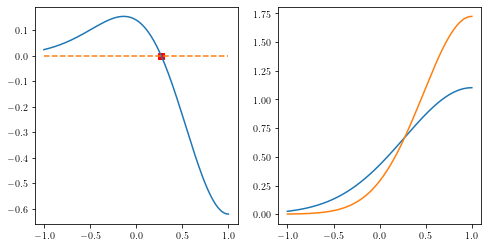

In [3]:
alpha, F_nue, F_nueb = 2*random.random(), random.random(), random.random() 
dis1, dis2 = GaussianDist(0.,0.), GaussianDist(0.,0.)
dis1.params_setter(1., F_nue)
dis2.params_setter(alpha, F_nueb)
cr, mu_c = AngDist.check_crossing(dis1, dis2)
x = np.arange(-1.,1.01,.01)   
G = dis1.angular_distribution(x) - dis2.angular_distribution(x) 

    
fig = plt.figure(figsize=(8,4))

fig.add_subplot(121)
if mu_c: plt.plot(mu_c,0,'rs')   
plt.plot(x,G)
plt.plot(x,G*0,'--')

fig.add_subplot(122)
plt.plot(x,dis1.angular_distribution(x))
plt.plot(x,dis2.angular_distribution(x))
print(cr)
print(mu_c)

In [4]:
dis1 = MaxentDist(0.,0.)
dis1.params_setter(1., 0.5)
print(dis1.args)
print(dis1.I0(*dis1.args))
print(dis1.flux_factor(*dis1.args))



(array([1.18288635]), array([1.79675598]))
[1.]
[0.5]


## Producing the data points for Gaussian and maximum entropy angular distributions
In the following cell, we produce the data sets using the Gaussian and maximum entropy angular distributions defined above.

In [5]:
def make_data(distribution_class, alpha_array, num_pnts):
    """ 
    This function makes a data set of angular distributions which provides the parameter values of a number
    of nu_e and nu_eb angular distributions, and whether there exists a crossing for those values.
        
    Parameters
    ----------
    distribution_class: python class
        the type of the neutrino angular distribution, currently MaxentDist & GaussianDist
    alpha_array : numpy 1D array
        includes the values of alpha = n_nueb/n_nue for which the ELN angular distribution is investigated
    num_pnts: int
        the number of random points in (F_nue, F_nueb) parameter space for each alpha
        
    Returns
    -------
    numpy array 
        of the size (alpha_array.size, NUM_PNTS, 8) where 8 refers to [alpha, F_nue, F_nueb, ELN_crossing, prm_nue1, prm_nue2,
        prm_nueb1, prm_nueb2] with prm_nue and prm_nueb being the parameters of nu_e and nu_eb distributions
    """
    
    data = np.zeros((alpha_array.size, num_pnts, 8))
    for alp in range(alpha_array.size):
        n = 0
        while n < num_pnts:
            alpha, F_nue, F_nueb = alpha_array[alp], random.random(), random.random() 
            dist1, dist2 = (distribution_class() for _ in range(2))
            dist1.params_setter(1., F_nue)            # The number density of nu_e = 1 (everything is normalized by n_nue)
            dist2.params_setter(alpha, F_nueb)
            # We only count the points if the solver has done its job correctly
            if dist1.check_solver() and dist2.check_solver():
                data[alp, n, :3] = alpha, F_nue, F_nueb
                if AngDist.check_crossing(dist1, dist2)[0]: data[alp, n, 3] = 1      # if ELN crossing is absent, it is 0
                data[alp, n, 4:] = *dist1.args, *dist2.args                       # the parameters, e.g, a & eta
                n += 1
    return data 


# The array of alpha and the the number of random points in (F_nue, F_nueb) parameter space for each alpha
# for which we find the angular distributions.
ALPHA = np.arange(0.001,2.5,.03)
NUM_PNTS = 700


# Producing two angular distributions with the dimensions (ALPHA.size, NUM_PNTS, 8)
# This might take ~1-2 minutes
data_max_ent = make_data(MaxentDist, ALPHA, NUM_PNTS) 
data_gaussian= make_data(GaussianDist, ALPHA, NUM_PNTS)



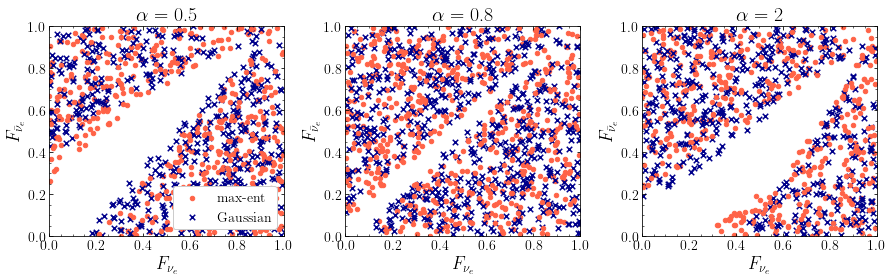

In [6]:
def make_subplots(alpha, legend=False):
    """ 
    This function makes a scatter plot of the zones for which ELN crossing exist, in (F_nue, F_nueb), given alpha.
        
    """
    
    plt.title(r'$\alpha = $ ' + str(alpha), size=20)
    plt.xlabel(r'$F_{\nu_e}$',size=18)
    plt.ylabel(r'$F_{\bar\nu_e}$',size=18)
    plt.scatter(2, 2, marker='o',color='tomato',s=20, alpha=1); 
    plt.scatter(2, 2, marker='x',color='darkblue',s=30, alpha=1)
    alpha_ind = np.argmin(abs(data_gaussian[:,0,0]-alpha))
    for i in range(0, NUM_PNTS):
        if data_max_ent[alpha_ind,i,3]>0:
            plt.scatter(data_max_ent[alpha_ind,i,1], data_max_ent[alpha_ind,i,2], marker='o', rasterized=True, label='',color='tomato',s=20, alpha=1)
        if data_gaussian[alpha_ind,i,3]>0:
            plt.scatter(data_gaussian[alpha_ind,i,1], data_gaussian[alpha_ind,i,2], marker='x', rasterized=True, label='',color='darkblue',s=30, alpha=1)
    plt.minorticks_on()
    plt.tick_params(axis='y',which='both',left=True,right=True,labelleft=True, direction='in')
    plt.tick_params(axis='x',which='both',top=True,bottom=True,labelbottom=True, direction='in')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(-0.0001,1.)
    plt.xlim(-0.0001,1.)
    if legend: plt.legend(("max-ent","Gaussian"), loc = 'lower right', fontsize=14, fancybox=True, framealpha=1.)



fig = plt.figure(figsize=(12.5,4))

fig.add_subplot(131); make_subplots(0.5, legend=True)
fig.add_subplot(132); make_subplots(0.8)
fig.add_subplot(133); make_subplots(2)
plt.tight_layout() 
plt.show()

# fig.savefig("Fig_prmspace.pdf")

In [7]:
from sklearn.model_selection import train_test_split

data = np.concatenate((data_gaussian, data_max_ent), axis=1)     # combine the two data sets

X = data[:,:,:3].reshape(data[:,0,0].size*data[0,:,0].size, 3)
y = data[:,:,3].reshape(data[:,0,0].size*data[0,:,0].size)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)

In [16]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, scale


lin_mod = LogisticRegression(max_iter=100000, class_weight={0: 2, 1: 1}, )

# We first make a polynomial transfomration to use the LR for a nonlinear problem
poly = PolynomialFeatures(degree = 9, interaction_only=False, include_bias=False)
XX_train = poly.fit_transform(X_train); XX_test = poly.fit_transform(X_test)
# XX_train = scale(XX_train); XX_test = scale(XX_test)

lin_mod.fit(XX_train,y_train)
prediction = lin_mod.predict(XX_test)
target_names = ['no crossing', 'crossing']
score = sklearn.metrics.classification_report(y_test, prediction, target_names=target_names)
print(score)

              precision    recall  f1-score   support

 no crossing       0.83      0.93      0.88      6237
    crossing       0.97      0.93      0.95     17283

    accuracy                           0.93     23520
   macro avg       0.90      0.93      0.92     23520
weighted avg       0.94      0.93      0.93     23520



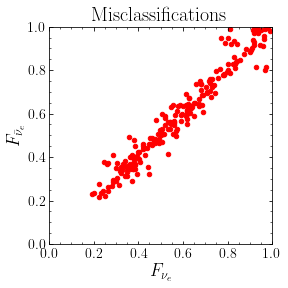

In [9]:
fig = plt.figure(figsize=(4,4))
plt.title('Misclassifications', size=20)
plt.xlabel(r'$F_{\nu_e}$',size=18)
plt.ylabel(r'$F_{\bar\nu_e}$',size=18)
plt.minorticks_on()
plt.tick_params(axis='y',which='both',left=True,right=True,labelleft=True, direction='in')
plt.tick_params(axis='x',which='both',top=True,bottom=True,labelbottom=True, direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-0.0001,1.)
plt.xlim(-0.0001,1.)

for i in range(prediction.size):
    if (prediction[i]-y_test[i])>1.e-3 and XX_test[i,0]>0.7 and XX_test[i,0]<1.3:
        plt.scatter(XX_test[i,1], XX_test[i,2], marker='o',color='red',s=20, alpha=1); 


In [63]:
# Saving the coef. of the Logistic Regression classifier and poly.fit_transform
np.save("poly_powers_",  poly.powers_)
np.save("lin_mod_intercept_", lin_mod.intercept_)
np.save("lin_mod_coef_", lin_mod.coef_)

In [12]:
# We here build the Logistic Regression classifier using LogisticRegression coef_
poly_powers_ = np.load("poly_powers_.npy")
lin_mod_intercept_ = np.load("lin_mod_intercept_.npy")
lin_mod_coef_ = np.load("lin_mod_coef_.npy")

x0 = np.array([ .9, .5, .6])           # an example with [alpha, F_nue, F_nueb] 


# One can produce the poly.fit_transform ourselves using poly.powers_
print("shape of poly_powers_: ", poly_powers_.shape)
x0_transformed = np.zeros((poly_powers_[:,0].size))
for i in range(poly_powers_[:,0].size):
    x0_transformed[i] = x0[0]**poly_powers_[i,0] * x0[1]**poly_powers_[i,1] * x0[2]**poly_powers_[i,2]
        
# One can then use the LogisticRegression coef_ and intercept_
print("shape of LR coef_: ", lin_mod_coef_.shape)
z = lin_mod_intercept_ + np.dot(x0_transformed, np.squeeze(lin_mod_coef_))
print("probability of an ELN crossing using coef. = ", 1./(1. + np.exp(-z)))


# And from calling the modul we have ... 
print("probability of an ELN crossing using lin_mod.predict_proba function = ",
      lin_mod.predict_proba(poly.fit_transform(x0.reshape(1,3)))[0,1])


shape of poly_powers_:  (219, 3)
shape of LR coef_:  (1, 219)
probability of an ELN crossing using coef. =  [0.74204483]
probability of an ELN crossing using lin_mod.predict_proba function =  0.7646612191041928


# knn

In [65]:
import sklearn
from sklearn import metrics, neighbors

knn = neighbors.KNeighborsClassifier(n_neighbors=3, weights='distance')
knn.fit(X_train,y_train)

prediction = knn.predict(X_test)

target_names = ['no crossing', 'crossing']
print(sklearn.metrics.classification_report(y_test, prediction, target_names=target_names))



# Here we comment on the idea of cross validation. 
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
scores = cross_val_score(knn, X, y, cv=5)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
print("cross validation scores, with n_splits=5:")
print(cross_val_score(knn, X, y, cv=cv))



              precision    recall  f1-score   support

 no crossing       0.90      0.90      0.90      6349
    crossing       0.96      0.96      0.96     17171

    accuracy                           0.95     23520
   macro avg       0.93      0.93      0.93     23520
weighted avg       0.95      0.95      0.95     23520

cross validation scores, with n_splits=5:
[0.9457483  0.94596088 0.94608844 0.94536565 0.94672619]


# SVM

In [66]:
from sklearn import svm

SVM = svm.SVC(kernel='rbf', gamma=100.01)
SVM.fit(X_train,y_train)

prediction = SVM.predict(X_test)

target_names = ['no crossing', 'crossing']
print(sklearn.metrics.classification_report(y_test, prediction, target_names=target_names))

              precision    recall  f1-score   support

 no crossing       0.92      0.90      0.91      6349
    crossing       0.96      0.97      0.97     17171

    accuracy                           0.95     23520
   macro avg       0.94      0.93      0.94     23520
weighted avg       0.95      0.95      0.95     23520



# Decision Tree Classifier

In [69]:
from sklearn.tree import DecisionTreeClassifier

mod = DecisionTreeClassifier(class_weight={0: 2, 1: 1})
mod.fit(X_train,y_train)

prediction = mod.predict(X_test)

target_names = ['class 0', 'class 1']
print(sklearn.metrics.classification_report(y_test, prediction, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.89      0.88      0.89      6349
     class 1       0.96      0.96      0.96     17171

    accuracy                           0.94     23520
   macro avg       0.92      0.92      0.92     23520
weighted avg       0.94      0.94      0.94     23520



In [85]:
class Temp:
    def __init__(self, *args, **kwargs):
        self.params = args
        self.kwparams = kwargs
        
    def temp(x):
        print(x) 
        
    def func(self):
        for a in (self.params):
            print(a)
        for a in self.kwparams:
            print(self.kwparams[a])       
            
    def setter(self):
        self.params = (9,10,11)
        

        
args = (2,3,4)
t1 = Temp() 
# t1.setter(5,6)
t1.func()
t1.setter()
t1.params
# Temp.params
# dic={'a':1, 'b':2}
# for a in dic:
#     print (dic[a])

# list_ = ['a','b']
# x='c'
# if x is not  list_: print('no')
   
# from numpy import *
# import numpy as np
# x = arange(-1.,1.,.001)
# type(x)
# x = 1
# a = x
# a += 1
# print(x)
dist1, dist2 = (AngDist('Gaussian') for _ in range(2))
type(dist1)


ang1 = AngDist('max_ent')
ang1.params_setter(0.92317189, 0.84775564)
print(*ang1.args)

# eta , a
# ang1 = AngDist('Gaussian', 3.46010815, 0.10634835)
# ang2 = AngDist('Gaussian', 1.20667207, 0.64976489)
# AngDist.check_crossing(ang1, ang2)
# 3.04010292, 1.92592123
class ttt:
    def __init__(self, *args, **kwargs):
        self.args = args
        self.kwargs = kwargs
    def func(self):
        print(self.args)
    def func3(self):
        self.func2()
    

a = ttt(2)
a.func()

class zzz(ttt):
    def __init__(self, *args, **kwargs):
        self.args = args
        self.kwargs = kwargs
    def func2(self):
        print("I am sajad")
    
mem1 = zzz()
mem1.func3()

AttributeError: 'AngDist' object has no attribute 'flux_factor'

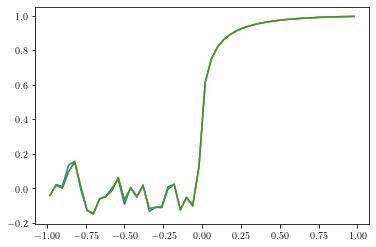

In [48]:
x=loadtxt("fv.dat")
plot(x[:,0],x[:,1])
plot(x[:,0],x[:,2])
plot(x[:,0],x[:,4])


0.016088666428316054 0.05398641401501609 0.004290311047550947 0.011798355380765105 0.02040723312142195 0.030579187217433832


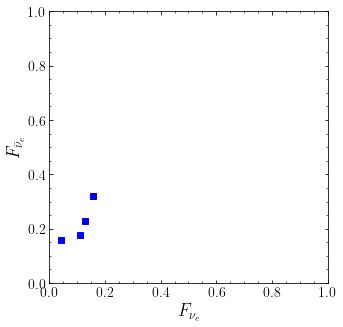

In [99]:
x=np.loadtxt("output.dat")
# plot(x[:,0],x[:,3]-x[:,5])
# plot(x[:,0],x[:,5])
(x[2000,1]-x[2000,3])/x[2000,1]

n_10, m_10, n_20, m_20, Err, Errb = 0,0,0,0,0,0
list_err, list_errb = [], []

for i in range(x[:,0].size):
    err = abs(x[i,1]-x[i,3])/x[i,1]
    errb = abs(x[i,2]-x[i,4])/x[i,2]
    Err += err/x[:,0].size
    Errb +=  errb/x[:,0].size
    if err>.1: n_10+=1
    if errb>.1: m_10+=1
    if err>.2: n_20+=1; 
    if errb>.2: m_20+=1
    if err>.3 or errb>.3: 
       list_err.append(x[i,1]); list_errb.append(x[i,2])
    
print(n_10/x[:,0].size, m_10/x[:,0].size, n_20/x[:,0].size, m_20/x[:,0].size, Err, Errb)    
fig = plt.figure(figsize=(5,5))
plt.minorticks_on()
plt.plot(list_err, list_errb, 'bs')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel(r'$F_{\nu_e}$',size=18)
plt.ylabel(r'$F_{\bar\nu_e}$',size=18)
plt.tick_params(axis='y',which='both',left=True,right=True,labelleft=True, direction='in')
plt.tick_params(axis='x',which='both',top=True,bottom=True,labelbottom=True, direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig.savefig("F.pdf")

0.0144 0.0539 0.0032 0.0103 0.019725015997426057 0.029456360492362724


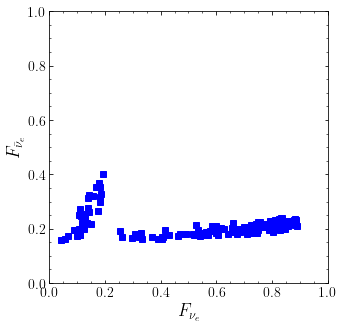

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy import integrate
from scipy import special
from scipy.optimize import fsolve
import math
import random
x = np.loadtxt ("Gaussian_output.dat")
n_10, m_10, n_20, m_20, Err, Errb = 0,0,0,0,0,0
list_err, list_errb = [], []

for i in range(x[:,0].size):
    err = abs(x[i,1]-x[i,3])/x[i,1]
    errb = abs(x[i,2]-x[i,4])/x[i,2]
    Err += err/x[:,0].size
    Errb +=  errb/x[:,0].size
    if err>.1: n_10+=1
    if errb>.1: m_10+=1
    if err>.2: n_20+=1; 
    if errb>.2: m_20+=1
    if err>.2 or errb>.2: 
       list_err.append(x[i,1]); list_errb.append(x[i,2])
    
print(n_10/x[:,0].size, m_10/x[:,0].size, n_20/x[:,0].size, m_20/x[:,0].size, Err, Errb)    
fig = plt.figure(figsize=(5,5))
plt.minorticks_on()
plt.plot(list_err, list_errb, 'bs')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel(r'$F_{\nu_e}$',size=18)
plt.ylabel(r'$F_{\bar\nu_e}$',size=18)
plt.tick_params(axis='y',which='both',left=True,right=True,labelleft=True, direction='in')
plt.tick_params(axis='x',which='both',top=True,bottom=True,labelbottom=True, direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig.savefig("F.pdf")

0.9502 0.9268 0.8993 0.8481 0.646631258933807 0.692696332370735


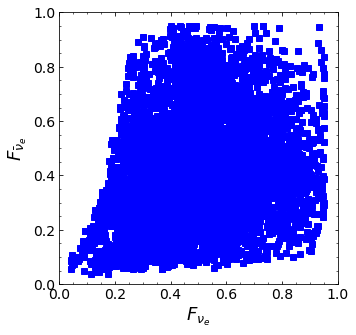

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy import integrate
from scipy import special
from scipy.optimize import fsolve
import math
import random
x = np.loadtxt ("Maxent_output.dat")
n_10, m_10, n_20, m_20, Err, Errb = 0,0,0,0,0,0
list_err, list_errb = [], []

for i in range(x[:,0].size):
    err = abs(x[i,1]-x[i,3])/x[i,1]
    errb = abs(x[i,2]-x[i,4])/x[i,2]
    Err += err/x[:,0].size
    Errb +=  errb/x[:,0].size
    if err>.1: n_10+=1
    if errb>.1: m_10+=1
    if err>.2: n_20+=1; 
    if errb>.2: m_20+=1
    if err>.2 or errb>.2: 
       list_err.append(x[i,1]); list_errb.append(x[i,2])
    
print(n_10/x[:,0].size, m_10/x[:,0].size, n_20/x[:,0].size, m_20/x[:,0].size, Err, Errb)    
fig = plt.figure(figsize=(5,5))
plt.minorticks_on()
plt.plot(list_err, list_errb, 'bs')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel(r'$F_{\nu_e}$',size=18)
plt.ylabel(r'$F_{\bar\nu_e}$',size=18)
plt.tick_params(axis='y',which='both',left=True,right=True,labelleft=True, direction='in')
plt.tick_params(axis='x',which='both',top=True,bottom=True,labelbottom=True, direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig.savefig("F.pdf")

In [3]:
x = np.loadtxt ("Maxent_output.dat")
x[100,:]

array([1.01000e+02, 6.41206e-01, 3.27411e-01, 3.36930e-02, 1.61354e-01,
       3.36930e-02, 1.61354e-01])